# Projeto Lakehouse para Detecção de Fraudes

O projeto consiste na criação de um pipeline de dados completo, desde a exploração dos dados até as camadas do Lakehouse, incluindo o treinamento de modelos de Machine Learning e a criação de um dashboard com os principais indicadores.

Hoje, lidamos com muitos cenários de fraudes de cartões de crédito. O projeto irá ajudar a identificar alguns desses cenários que podem ser encontrados.

Este projeto é baseado no livro [Reproducible Machine Learning for Credit Card detecteion Pratical handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html), que apresenta informações importantes sobre os cenários de detecção de fraude, além dos sistemas atualmente existentes e a simulação de dados para a implementação dos modelos de Machine Learning para identificação.

Este projeto foi desenvolvido com base no [Fraud Detection Handbook](https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook), de Yann-Aël Le Borgne, Wissam Siblini, Bertrand Lebichot e Gianluca Bontempi.
O código-fonte original está licenciado sob a GNU GPL v3.0 e os textos/imagens sob CC BY-SA 4.0.

## Imports

In [21]:
import datetime
import time
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

## 1. Simulador de Dados de transação

Apresentaremos um simulador de dados de transações legítimas e fraudulentas que se aproxima da realidade. Ele reflete a profundidade do funcionamento dos dados de transação com cartão de pagamento do mundo real, tudo isso com uma configuração simples para a apresentação dos dados.

### ***Features de Transação***

objetivo será simular as características primordiais das transações. A princípio, as transações de pagamento com cartão envolvem o valor a ser pago por um cliente a um lojista em determinado momento. Os principais atributos que sumarizam uma transação são:

1. **ID da Transação**: Uma identificação única para a transação.
2. **Data e Hora**: O momento em que a transação ocorreu.
3. **ID do Cliente**: O identificador único para cada cliente.
4. **ID do Terminal**: O identificador único para o comerciante (será identificado como terminal).
5. **Valor**: O valor da transação.
6. **Rótulo da Fraude**: Uma variável binária, com valor 0 para transações não fraudulentas ou valor 1 para transações fraudulentas.

### ***Processo de geração de transações***

A simulação **consiste** em cinco etapas principais:

1.  **Geração de Perfis de Clientes**: Cada cliente possui **hábitos** de consumo distintos. Isso será simulado definindo algumas propriedades para cada cliente, como seu **ID**, **geolocalização**, **frequência** de gastos e o valor gasto. As propriedades do cliente serão **representadas** em um **DataFrame** denominado `customer_profiles_table`.

2.  **Geração de Perfis de Terminais**: As propriedades do terminal (**lojista** ou **comerciante**) **consistirão** unicamente em sua **localização geográfica** e seu **ID**. Suas propriedades serão **representadas** em um **DataFrame** denominado `terminal_profiles_table`.

3.  **Associação de Perfis de Clientes com Terminais**: Um exemplo simples é associar clientes a terminais que estão dentro de um raio ***r*** de sua **localização geográfica**. Isso simplifica a premissa de que um cliente **faz transações** apenas em terminais geograficamente **próximos** à sua localização. Esta etapa **consistirá em adicionar** um recurso `list_terminals` a cada perfil de cliente, que **contém o conjunto** de terminais **que** o cliente pode usar.

4.  **Geração de Transações**: O simulador **irá gerar** **transações** com base nos perfis dos clientes e suas propriedades (**frequência**, valor gasto, terminais **disponíveis**). Isso resultará em um **DataFrame** de **transações**.

5.  **Geração de Cenários de Fraude**: Este **último** passo **trará rótulos** às **transações**, classificando-as como **legítimas ou fraudulentas**. Isso será feito seguindo três diferentes cenários de fraudes.



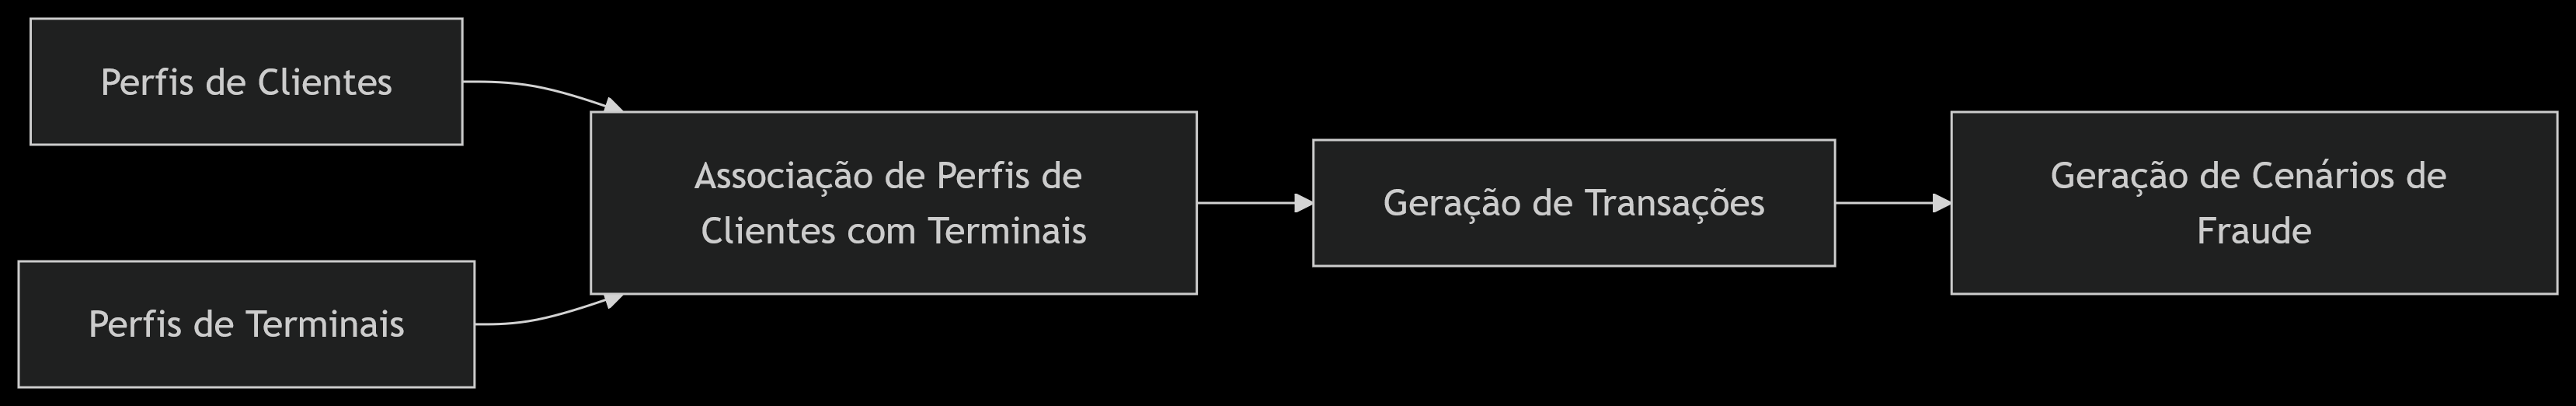

### 1.1. Geração de perfis de clientes

Todos os clientes terão os seguintes atributos:

* **CUSTOMER\_ID**: O ID único do cliente.
* **x\_customer\_id** e **y\_customer\_id**: Um par de coordenadas reais em uma grade 100x100 que define a **localização geográfica** do cliente.
* **mean\_amount** e **std\_amount**: A média e o desvio padrão dos valores **das transações** do cliente, assumindo que os valores das transações seguem uma **distribuição normal**. O `mean_amount` será obtido a partir de uma distribuição uniforme (5, 100) e `std_amount` será definido como o `mean_amount` dividido por dois.
* **mean\_nb\_tx\_per\_day**: O **número** médio de **transações feitas** por dia pelo cliente, assumindo que o **número de transações** por dia segue uma **distribuição de Poisson**. Este **número** será obtido **a partir de** uma distribuição uniforme.

A função `generate_customer_profiles_table` fornece um **Dataframe** com os perfis dos clientes. **Ela** recebe como entrada o **número** de clientes (`n_customers`) para os quais **gera** um perfil e **um** estado aleatório para reprodutibilidade.



In [55]:
def generate_customer_profiles_table(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

In [57]:
n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049


### 1.2. Geração de perfis de terminais

Cada terminal terá **os seguintes atributos**:

* **TERMINAL_ID**: O ID único de cada terminal.
* **x_terminal_id, y_terminal_id**: Par de coordenadas reais em uma grade 100x100, que define a localização geográfica do terminal.

A função `generate_terminal_profiles_table` **é uma implementação que gera** um **Dataframe** (uma estrutura de dados tabular) com os perfis dos terminais. Ela recebe como entrada o número de terminais e, a partir desse número, gera os perfis em um estado aleatório que permite a **reprodutibilidade** (ou seja, os resultados podem ser recriados).


In [84]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

In [30]:
n_terminals = 5
terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 0)
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


### 1.3. Associação de perfis de clientes a terminais

Neste projeto, os **clientes** só podem realizar **transações** em terminais que estejam dentro de um raio `r` de sua localização **geográfica**.

A função `get_list_terminals_within_radius` encontra esses terminais para um perfil de cliente. Essa função receberá o perfil do cliente, um *array* (ou lista) que contém a localização geográfica de todos os terminais, e o raio `r`. Ela retornará a lista de terminais localizados dentro desse **raio** `r` para os clientes.


In [92]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals
    

A **demonstração** abaixo é um exemplo em que usamos o perfil do **último** cliente e definimos o raio como 50.

Nessa **demonstração**, que pode ser observada na figura, os **únicos** terminais localizados dentro da **circunferência** de raio 50 para o **último** cliente são os terminais **2 e 3**, que se encontram a um raio menor. Com base nisso, podemos **definir** em quais terminais os **clientes** podem se locomover.


In [115]:
# We first get the geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
# And get the list of terminals within radius of $50$ for the last customer
get_list_terminals_within_radius(customer_profiles_table.iloc[4], x_y_terminals=x_y_terminals, r=50)

[2, 3]

In [117]:
%%capture

terminals_available_to_customer_fig, ax = plt.subplots(figsize=(5,5))

# Plot locations of terminals
ax.scatter(terminal_profiles_table.x_terminal_id.values, 
           terminal_profiles_table.y_terminal_id.values, 
           color='blue', label = 'Locations of terminals')

# Plot location of the last customer
customer_id=4
ax.scatter(customer_profiles_table.iloc[customer_id].x_customer_id, 
           customer_profiles_table.iloc[customer_id].y_customer_id, 
           color='red',label="Location of last customer")

ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))

# Plot the region within a radius of 50 of the last customer
circ = plt.Circle((customer_profiles_table.iloc[customer_id].x_customer_id,
                   customer_profiles_table.iloc[customer_id].y_customer_id), radius=50, color='g', alpha=0.2)
ax.add_patch(circ)

fontsize=15

ax.set_title("Círculo verde: \n Terminais num raio de 50 \n do último cliente")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
    
ax.set_xlabel('x_terminal_id', fontsize=fontsize)
ax.set_ylabel('y_terminal_id', fontsize=fontsize)

**A figura ilustra:**
* A localização de todos os terminais (em azul).
* A localização do **último** cliente (em vermelho).
* A região dentro de um raio de 50 do **último** cliente (em verde)."

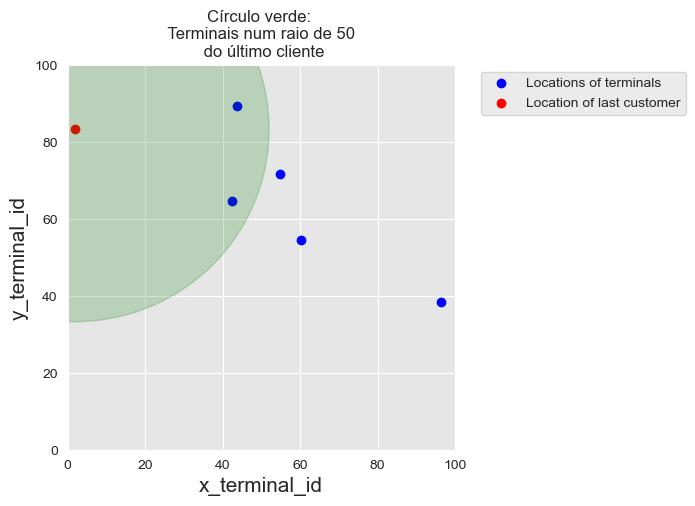

In [108]:
terminals_available_to_customer_fig

In [96]:
customer_profiles_table['available_terminals']=customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50), axis=1)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[0, 1, 2, 3]"
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[0, 1, 2, 3]"
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[1, 4]"
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[0, 1, 2, 3]"
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[2, 3]"


### 1.4. Geração de transações

Os perfis dos clientes contêm todas as informações fundamentais **para** gerar **transações**. **A** geração de **transações** será feita pela função `generate_transactions_table`, que recebe como entrada um perfil de cliente, uma data de início e um número de dias para os quais as transações serão geradas. Ela retornará um **DataFrame** de **transações**.


In [125]:
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  
    
    

#### Ampliando para um conjunto de dados maior

Seguindo **os mesmos passos** do livro, utilizaremos a função `generate_dataset`, **a qual** realizará todos os passos anteriores.

Essa função **receberá** como entradas:
* O número de clientes, terminais e dias desejados.
* A data de início e o raio `r`.

Ela **devolverá** a tabela de perfis de clientes e terminais gerados, além do **DataFrame** de transações.

In [140]:
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)
    

A primeira geração terá as seguintes características:

* 5.000 clientes
* 10.000 terminais
* 183 dias de operações (correspondentes ao **período** simulado de 2018/04/01 a 2018/09/30)
* Raio definido de 5 (que **corresponde** a 100 terminais **disponíveis** para cada cliente)


In [142]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 5000, 
                     n_terminals = 10000, 
                     nb_days=183, 
                     start_date="2018-04-01", 
                     r=5)

Time to generate customer profiles table: 0.04s
Time to generate terminal profiles table: 0.041s
Time to associate terminals to customers: 1.2s


C:\Users\Thiago\AppData\Local\Temp\ipykernel_24600\36116418.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_24600\36116418.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(

Time to generate transactions: 7e+01s


In [144]:
transactions_df.shape

(1754155, 7)

In [146]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0


### 1.5. Geração de cenários de fraude

Sabe, quando estamos simulando transações para **detectar fraudes**, a gente adiciona alguns "truques" ao sistema para ver se ele é esperto o suficiente para pegá-los. Pense nisso como um jogo de esconde-esconde, onde a gente esconde os "ladrões" de diferentes formas:

**Cenário 1:** Imagina que todo roubo acima de R\$ 220 é automaticamente considerado fraude. Esse é o nosso **ladrão mais óbvio**. Ele serve pra gente ter certeza que o nosso sistema de detecção de fraudes, mesmo o mais simples, consegue pegar algo tão na cara. É tipo um teste básico: se não pegar esse, algo está muito errado!


**Cenário 2:** Aqui, a gente simula que, de repente, alguns terminais (tipo as maquininhas de cartão) são "sequestrados" por bandidos por 28 dias. Todas as transações feitas nessas maquininhas durante esse período se tornam **fraudes**. É como se um criminoso usasse uma maquininha para aplicar golpes de *phishing* (aquelas mensagens falsas pra roubar dados). Para o sistema pegar isso, ele precisa ficar de olho em quantas transações estranhas acontecem em cada maquininha. Mas, como o roubo é temporário, o sistema também precisa ser inteligente para perceber quando a ameaça para.

**Cenário 3:** Nesse cenário, simulamos que as informações de alguns clientes são roubadas. Aí, por 14 dias, um terço das compras desses clientes têm os valores multiplicados por cinco e são marcadas como **fraude**. O cliente continua usando o cartão normalmente, mas o golpista também faz compras grandes para tirar o máximo de dinheiro. Para pegar esse tipo de fraude, o sistema precisa **conhecer o padrão de gastos de cada cliente**. Assim como no cenário anterior, ele também precisa ser esperto para entender quando o problema com o cartão passa.

Basicamente, estamos criando diferentes tipos de fraudes artificiais para testar o quão bem o nosso sistema consegue identificá-las e se adaptar às mudanças.

In [155]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df                 

In [157]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 978
Number of frauds from scenario 2: 9099
Number of frauds from scenario 3: 4604
CPU times: total: 1min 10s
Wall time: 1min 10s


In [159]:
transactions_df.TX_FRAUD.mean()

0.008369271814634397

In [161]:
transactions_df.TX_FRAUD.sum()

14681

In [163]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [177]:
transactions_df['TX_FRAUD_SCENARIO'].value_counts(dropna=False)

TX_FRAUD_SCENARIO
0    1739474
2       9077
3       4631
1        973
Name: count, dtype: int64

In [179]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [181]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

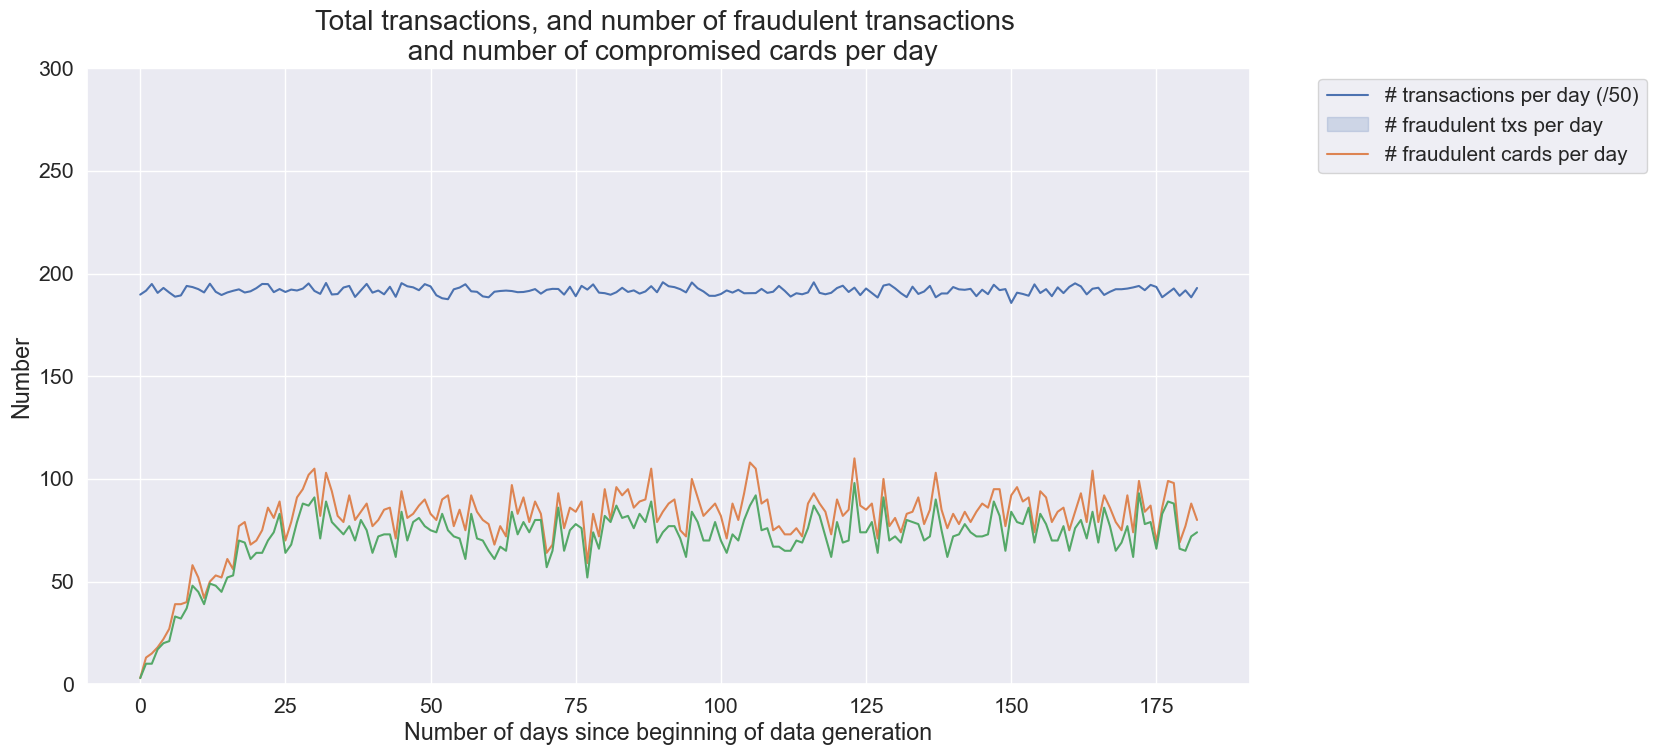

In [183]:
fraud_and_transactions_stats_fig

Essa simulação criou cerca de 10.000 transações por dia. Dentre elas, em média, 85 são fraudulentas e envolvem aproximadamente 80 cartões diferentes por dia. Um detalhe importante é que, no primeiro mês, o número de fraudes é menor. Isso acontece porque dois dos cenários simulados (os cenários 2 e 3) levam um tempo para começar a gerar fraudes — 28 e 14 dias, respectivamente.

O conjunto de dados final ficou bem interessante: ele apresenta um forte desequilíbrio entre classes (menos de 1% das transações são fraudes), mistura variáveis numéricas e categóricas, e traz relações complexas entre os dados, com fraudes que mudam ao longo do tempo — ou seja, mais próximas do que acontece no mundo real.

Analisei o texto que você forneceu com foco em concordância, coerência e clareza. Abaixo, detalho o feedback para cada ponto:

---

### **Análise do Texto:**

"Como fizemos todos os teste para entender as funções e os DataFrames que iremos trabalhar, Vamos aplicar todo esse processo para criar o dataframe no arquivo `01_generate_simulated_data.py` e salvar posteriormente no arquivo `data/raw`, sepadados por pasta e seus respectivo nome do arquivo."

---

### **Feedback Detalhado:**

#### **1. Concordância (verbal e nominal):**

* **Existem erros de concordância entre verbos e sujeitos?**
    * Sim. "Como fizemos todos os **teste**" - O correto seria "todos os **testes**" (concordância nominal: "teste" é plural e "todos os" também).
    * "Vamos aplicar todo esse processo para criar o **dataframe** no arquivo (...) e salvar posteriormente no arquivo `data/raw`, **sepadados** por pasta e seus **respectivo** nome do arquivo."
        * "sepadados" está incorreto, o correto é "separados".
        * "sepadados por pasta e seus respectivo nome do arquivo" - Esta parte está um pouco confusa e com problema de concordância. O que será "separado por pasta"? Os "arquivos" ou os "dataframes"? Além disso, "respectivo" deveria ser plural se referindo a "nomes" ou "arquivos" (se houver mais de um).
            * Se o objetivo é que os *arquivos* sejam separados por pasta: "salvar posteriormente no arquivo `data/raw`, **separados** por pasta e com **seus respectivos nomes de arquivo**." (Assumindo que cada arquivo salvo tem um nome, e estes nomes são "respectivos" às suas pastas).
            * Se o objetivo é que o *dataframe* seja salvo em arquivos separados por pasta e com nomes específicos: a frase precisa ser reestruturada para deixar isso claro.

* **A concordância entre substantivos e adjetivos, artigos e pronomes está correta?**
    * Não, como mencionado acima: "teste" (plural) e "respectivo" (plural se referindo a nomes/arquivos).

* **Há alguma ambiguidade causada por má concordância?**
    * Sim, a frase "sepadados por pasta e seus respectivo nome do arquivo" cria ambiguidade. Não fica claro se o `dataframe` será separado em várias pastas, ou se os arquivos gerados (que contêm o dataframe) serão organizados dessa forma.

#### **2. Coerência:**

* **As ideias são apresentadas de forma lógica e sequencial?**
    * A ideia principal (aplicar o processo de criação de dataframe e salvar) é lógica. A introdução ("Como fizemos todos os testes para entender as funções e os DataFrames que iremos trabalhar") estabelece um bom contexto para a ação que será tomada.

* **Há transições suaves entre os parágrafos e as sentenças?**
    * É uma única sentença, então a transição interna é ok, mas a fluidez é prejudicada pelos erros de concordância e pela estrutura da última parte.

* **Existe alguma informação redundante ou que quebre o fluxo de pensamento?**
    * Não há redundância. A parte "sepadados por pasta e seus respectivo nome do arquivo" quebra um pouco o fluxo pela sua falta de clareza e concordância.

* **O texto mantém uma linha de raciocínio consistente do início ao fim?**
    * Sim, a linha de raciocínio é consistente: preparar (testar) -> executar (criar dataframe) -> armazenar (salvar).

#### **3. Clareza e Compreensão do Leitor:**

* **A linguagem utilizada é adequada ao público-alvo?**
    * A linguagem mistura um tom mais formal ("Como fizemos todos os teste") com termos técnicos específicos de programação (`DataFrames`, `dataframe`, `01_generate_simulated_data.py`, `data/raw`). Isso é adequado para um público que já tem familiaridade com desenvolvimento de software e ciência de dados. Para um público leigo, os termos técnicos precisariam de explicação.

* **Existem termos técnicos ou jargões que precisam de explicação ou simplificação?**
    * Para o público técnico: `DataFrames` é um termo comum.
    * Para um público não técnico: Sim, `DataFrames` precisaria ser explicado como "tabelas de dados especiais". `01_generate_simulated_data.py` é um nome de arquivo Python, e `data/raw` é um caminho de diretório, que podem ser explicados como "o programa que simula os dados" e "a pasta onde os dados brutos serão guardados".

* **As frases são concisas e diretas, ou poderiam ser reescritas para maior clareza?**
    * A frase é relativamente concisa, mas a última parte a torna menos direta devido à falta de clareza e concordância.

* **Os pontos principais são facilmente identificáveis?**
    * Sim: "entender as funções e DataFrames" (preparação), "criar o dataframe" (ação principal), "salvar no arquivo `data/raw`" (destino).

* **Há alguma parte do texto que possa causar confusão ou interpretação equivocada no leitor?**
    * Sim, a parte final: "sepadados por pasta e seus respectivo nome do arquivo".
        * Ela deveria explicar *o que* será separado (os arquivos que contêm o dataframe, ou o próprio dataframe se dividido em múltiplos arquivos), e a concordância de "seus respectivo nome do arquivo" precisa ser ajustada.

* **O propósito do texto é claro para quem o lê?**
    * O propósito é claro: após os testes, o próximo passo é gerar e salvar o dataframe principal usando um script específico e em um local determinado.

---

### **Sugestão de Revisão do Texto:**

Considerando os pontos acima e visando manter a concisão, uma possível revisão seria:

"Após realizarmos todos os **testes** para compreender as funções e os DataFrames com os quais iremos trabalhar, aplicaremos todo esse processo para criar o **dataframe** no arquivo `01_generate_simulated_data.py`. Posteriormente, ele será salvo na pasta `data/raw`, com um nome de arquivo apropriado dentro de sua respectiva subpasta."

**Ou, se o foco for em *arquivos* salvos:**

"Após realizarmos todos os **testes** para compreender as funções e os DataFrames com os quais iremos trabalhar, aplicaremos todo esse processo para criar o **dataframe** no arquivo `01_generate_simulated_data.py`. Os arquivos resultantes serão salvos na pasta `data/raw`, **organizados** em subpastas e com **seus respectivos nomes**."

A primeira sugestão é um pouco mais concisa e mantém o foco no dataframe sendo salvo, enquanto a segunda enfatiza a organização dos *arquivos* gerados. A escolha depende do nuance que você quer dar.
